# Refactoring `Observer` Object: Testing

In [1]:
import subprocess
import os

import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as const
from astropy.coordinates import SkyCoord
from sunpy.coordinates import HeliographicStonyhurst, Helioprojective
import synthesizAR
import synthesizAR.extrapolate
from synthesizAR.interfaces.ebtel import EbtelInterface,RandomNanoflares,read_xml,run_ebtel
from synthesizAR.instruments import InstrumentSDOAIA
import distributed

%matplotlib inline

/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


First create synthetic magnetogram

In [2]:
shape = [ 50, 50] * u.pixel
obs = SkyCoord(lon=0.*u.deg,lat=0.*u.deg,radius=const.au,frame=HeliographicStonyhurst)
blc = SkyCoord(-50 * u.arcsec, -50 * u.arcsec,frame=Helioprojective(observer=obs))
trc = SkyCoord(50 * u.arcsec, 50 * u.arcsec, frame=Helioprojective(observer=obs))
centers = SkyCoord([15, -15,]*u.arcsec,[0, 0,]*u.arcsec,frame=Helioprojective(observer=obs))
sigmas = u.Quantity([[5, 5], [5, 5],],'arcsec')
amplitudes = u.Quantity([1e3, -1e3,], 'Gauss')
magnetogram = synthesizAR.extrapolate.synthetic_magnetogram(blc, trc, shape, centers, sigmas, amplitudes, observer=obs)

/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


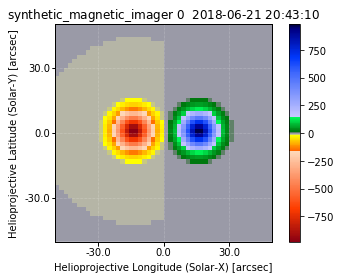

In [3]:
magnetogram.peek(cmap='hmimag')
plt.show()

In [4]:
shape_z = 50 * u.pixel
width_z = (magnetogram.scale.axis1 * shape_z).to(u.radian).value * magnetogram.dsun
extrapolator = synthesizAR.extrapolate.PotentialField(magnetogram, width_z, shape_z)
B_field = extrapolator.extrapolate()

In [5]:
fieldlines = extrapolator.trace_fieldlines(B_field, 200, notebook=True)

yt : [INFO     ] 2018-06-21 15:43:17,559 Parameters: current_time              = 0.0
yt : [INFO     ] 2018-06-21 15:43:17,560 Parameters: domain_dimensions         = [50 50 50]
yt : [INFO     ] 2018-06-21 15:43:17,564 Parameters: domain_left_edge          = [-3.60934452e+09 -3.60934063e+09  0.00000000e+00]
yt : [INFO     ] 2018-06-21 15:43:17,567 Parameters: domain_right_edge         = [3.60973916e+09 3.60973527e+09 7.25270944e+09]
yt : [INFO     ] 2018-06-21 15:43:17,569 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2018-06-21 15:43:17,813 AMRKDTree rebuilt, Final Volume: 3.779758e+29
Streamlining: 100%|██████████| 200/200 [00:00<00:00, 1034.91it/s]
yt : [INFO     ] 2018-06-21 15:43:18,185 AMRKDTree rebuilt, Final Volume: 3.779758e+29
Streamlining: 100%|██████████| 125/125 [00:00<00:00, 1034.33it/s]
yt : [INFO     ] 2018-06-21 15:43:18,452 AMRKDTree rebuilt, Final Volume: 3.779758e+29
Streamlining: 100%|██████████| 79/79 [00:00<00:00, 690.67it/s]
yt : [INFO     ] 2018-0

FloatProgress(value=0.0)

In [6]:
active_region = synthesizAR.Field(magnetogram,fieldlines)

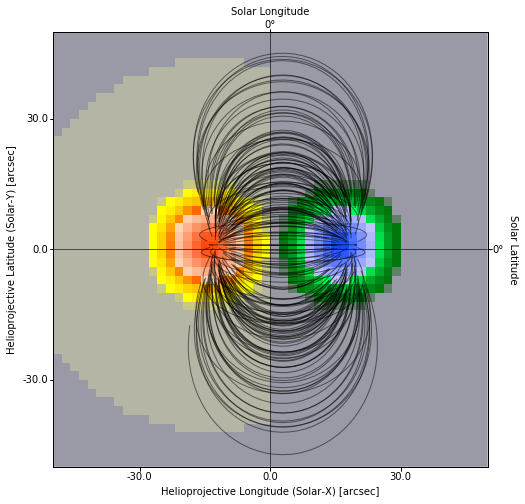

In [7]:
active_region.peek(line_frequency=1)

In [8]:
heating_model = RandomNanoflares(200*u.s,0.3)

In [9]:
base_config = read_xml('/Users/willbarnes/Documents/work/codes/ebtelPlusPlus/config/ebtel.example.cfg.xml')
base_config['total_time'] = 5e3
base_config['use_adaptive_solver'] = True
base_config['use_flux_limiting'] = True
base_config['c1_cond0'] = 6.0

In [10]:
ebtel = EbtelInterface(base_config,heating_model,'/Users/willbarnes/Desktop/synthesizar_sandbox/hydro_config','/Users/willbarnes/Desktop/synthesizar_sandbox/hydro_results')

In [11]:
active_region.configure_loop_simulations(ebtel)

FloatProgress(value=0.0)

In [12]:
for loop in active_region.loops:
    run_ebtel('/Users/willbarnes/Documents/work/codes/ebtelPlusPlus/', loop)

In [13]:
active_region.load_loop_simulations(ebtel, '/Users/willbarnes/Desktop/synthesizar_sandbox/loop_parameters.h5')

FloatProgress(value=0.0)

In [14]:
active_region.save('/Users/willbarnes/Desktop/synthesizar_sandbox/field_checkpoint')

In [2]:
active_region = synthesizAR.Field.restore('/Users/willbarnes/Desktop/synthesizar_sandbox/field_checkpoint')

In [3]:
aia = InstrumentSDOAIA([0,1000]*u.s,active_region.magnetogram.observer_coordinate,)

In [4]:
client = distributed.Client()
client

Client Scheduler: tcp://127.0.0.1:60675 Dashboard: http://127.0.0.1:60676/status,Cluster Workers: 4 Cores: 4 Memory: 17.18 GB


In [5]:
obs = synthesizAR.Observer(active_region,[aia],parallel=True)

In [6]:
obs.build_detector_files('/Users/willbarnes/Desktop/synthesizar_sandbox/',0.5*u.Mm)

/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:299: RuntimeWarning: A theoretically impossible result when finding a smoothing spline
with fp = s. Probable cause: s too small. (abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:299: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))


In [7]:
flat_futures = obs.flatten_detector_counts(interpolate_hydro_quantities=False)

/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/bokeh/core/json_encoder.py:80: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(type(obj), np.float):


In [8]:
bin_futures = obs.bin_detector_counts('/Users/willbarnes/Desktop/synthesizar_sandbox/')

KeyboardInterrupt: 